# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

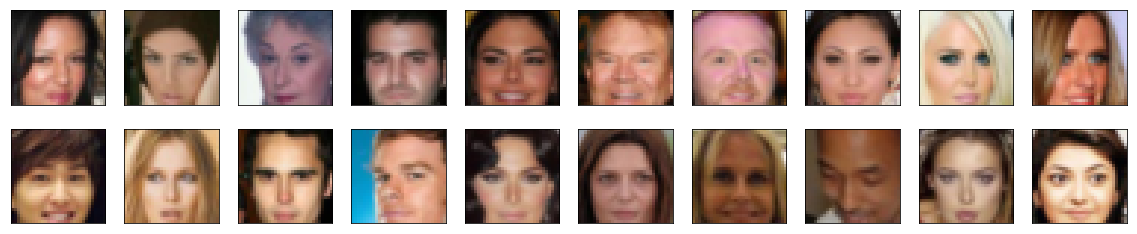

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9451)
Max:  tensor(0.9608)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) 
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        # flatten
        x = x.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        return self.fc(x)        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4) 
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        x = self.t_conv3(x)
        
        return torch.tanh(x)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1,

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # with 0.9 smoothing
    labels = torch.ones(batch_size)*0.9
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.1
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.3896 | g_loss: 0.7120
Epoch [    1/   30] | d_loss: 0.4215 | g_loss: 2.4823
Epoch [    1/   30] | d_loss: 0.6046 | g_loss: 2.9860
Epoch [    1/   30] | d_loss: 0.6917 | g_loss: 2.1481
Epoch [    1/   30] | d_loss: 0.8888 | g_loss: 1.5315
Epoch [    1/   30] | d_loss: 0.6846 | g_loss: 1.9044
Epoch [    1/   30] | d_loss: 0.8642 | g_loss: 2.2601
Epoch [    1/   30] | d_loss: 1.0300 | g_loss: 1.1532
Epoch [    1/   30] | d_loss: 0.9309 | g_loss: 1.6460
Epoch [    1/   30] | d_loss: 1.1321 | g_loss: 0.9860
Epoch [    1/   30] | d_loss: 1.1945 | g_loss: 0.9222
Epoch [    1/   30] | d_loss: 1.0803 | g_loss: 1.0615
Epoch [    1/   30] | d_loss: 1.1977 | g_loss: 1.7774
Epoch [    1/   30] | d_loss: 1.2002 | g_loss: 1.8000
Epoch [    1/   30] | d_loss: 1.2311 | g_loss: 1.3552
Epoch [    1/   30] | d_loss: 1.2445 | g_loss: 1.4723
Epoch [    1/   30] | d_loss: 1.2689 | g_loss: 0.9880
Epoch [    1/   30] | d_loss: 1.2374 | g_loss: 1.1601
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 1.1518 | g_loss: 0.8993
Epoch [    3/   30] | d_loss: 1.2496 | g_loss: 0.9363
Epoch [    3/   30] | d_loss: 1.1661 | g_loss: 1.1155
Epoch [    3/   30] | d_loss: 1.2450 | g_loss: 1.6062
Epoch [    3/   30] | d_loss: 1.1350 | g_loss: 1.3182
Epoch [    3/   30] | d_loss: 1.1186 | g_loss: 1.3637
Epoch [    3/   30] | d_loss: 1.1639 | g_loss: 1.3627
Epoch [    3/   30] | d_loss: 1.5905 | g_loss: 0.7237
Epoch [    3/   30] | d_loss: 1.1486 | g_loss: 1.3755
Epoch [    3/   30] | d_loss: 1.0961 | g_loss: 0.9531
Epoch [    3/   30] | d_loss: 1.1606 | g_loss: 0.8918
Epoch [    3/   30] | d_loss: 1.3074 | g_loss: 0.9873
Epoch [    3/   30] | d_loss: 1.1117 | g_loss: 0.9689
Epoch [    3/   30] | d_loss: 1.1989 | g_loss: 1.3064
Epoch [    3/   30] | d_loss: 1.2141 | g_loss: 0.6767
Epoch [    3/   30] | d_loss: 1.2377 | g_loss: 1.0509
Epoch [    3/   30] | d_loss: 1.1493 | g_loss: 1.0064
Epoch [    3/   30] | d_loss: 1.1203 | g_loss: 0.9762
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 1.6824 | g_loss: 0.7230
Epoch [    6/   30] | d_loss: 0.8690 | g_loss: 1.3848
Epoch [    6/   30] | d_loss: 0.9851 | g_loss: 1.1011
Epoch [    6/   30] | d_loss: 0.8585 | g_loss: 1.3212
Epoch [    6/   30] | d_loss: 1.2246 | g_loss: 2.8591
Epoch [    6/   30] | d_loss: 0.8384 | g_loss: 1.1708
Epoch [    6/   30] | d_loss: 1.0130 | g_loss: 0.9099
Epoch [    6/   30] | d_loss: 1.1091 | g_loss: 0.6949
Epoch [    6/   30] | d_loss: 0.7718 | g_loss: 1.8527
Epoch [    6/   30] | d_loss: 0.8712 | g_loss: 1.8205
Epoch [    6/   30] | d_loss: 0.9590 | g_loss: 1.2012
Epoch [    6/   30] | d_loss: 0.9146 | g_loss: 1.2508
Epoch [    6/   30] | d_loss: 0.9620 | g_loss: 1.3132
Epoch [    6/   30] | d_loss: 0.7007 | g_loss: 1.7278
Epoch [    6/   30] | d_loss: 0.9700 | g_loss: 1.1277
Epoch [    6/   30] | d_loss: 0.8957 | g_loss: 2.4230
Epoch [    6/   30] | d_loss: 1.0342 | g_loss: 1.9592
Epoch [    6/   30] | d_loss: 0.8496 | g_loss: 1.8212
Epoch [    6/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.6676 | g_loss: 2.0050
Epoch [    9/   30] | d_loss: 0.7490 | g_loss: 1.1413
Epoch [    9/   30] | d_loss: 0.8881 | g_loss: 2.4041
Epoch [    9/   30] | d_loss: 0.8182 | g_loss: 1.3328
Epoch [    9/   30] | d_loss: 1.2696 | g_loss: 0.9114
Epoch [    9/   30] | d_loss: 1.1126 | g_loss: 1.0848
Epoch [    9/   30] | d_loss: 0.5708 | g_loss: 1.5176
Epoch [    9/   30] | d_loss: 0.6306 | g_loss: 1.7807
Epoch [    9/   30] | d_loss: 0.6025 | g_loss: 2.3728
Epoch [    9/   30] | d_loss: 0.7584 | g_loss: 1.7453
Epoch [    9/   30] | d_loss: 1.2663 | g_loss: 2.9892
Epoch [    9/   30] | d_loss: 0.9356 | g_loss: 2.6493
Epoch [    9/   30] | d_loss: 1.2286 | g_loss: 0.7480
Epoch [    9/   30] | d_loss: 0.8232 | g_loss: 1.9781
Epoch [    9/   30] | d_loss: 1.1774 | g_loss: 1.1092
Epoch [    9/   30] | d_loss: 0.7989 | g_loss: 2.4040
Epoch [    9/   30] | d_loss: 0.6994 | g_loss: 1.3541
Epoch [    9/   30] | d_loss: 2.1394 | g_loss: 0.7118
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.6326 | g_loss: 2.2344
Epoch [   11/   30] | d_loss: 0.7380 | g_loss: 1.6394
Epoch [   11/   30] | d_loss: 0.6305 | g_loss: 2.0491
Epoch [   11/   30] | d_loss: 0.6463 | g_loss: 2.1794
Epoch [   11/   30] | d_loss: 0.8389 | g_loss: 2.6924
Epoch [   11/   30] | d_loss: 0.6702 | g_loss: 1.5355
Epoch [   11/   30] | d_loss: 0.5340 | g_loss: 2.4584
Epoch [   11/   30] | d_loss: 0.6384 | g_loss: 2.7030
Epoch [   11/   30] | d_loss: 0.6095 | g_loss: 1.9226
Epoch [   11/   30] | d_loss: 0.7040 | g_loss: 1.8184
Epoch [   11/   30] | d_loss: 0.4791 | g_loss: 1.8119
Epoch [   11/   30] | d_loss: 0.5763 | g_loss: 2.1468
Epoch [   11/   30] | d_loss: 0.5380 | g_loss: 2.3371
Epoch [   11/   30] | d_loss: 1.0889 | g_loss: 1.0509
Epoch [   11/   30] | d_loss: 0.4778 | g_loss: 1.9408
Epoch [   11/   30] | d_loss: 0.5745 | g_loss: 2.0874
Epoch [   11/   30] | d_loss: 0.6188 | g_loss: 2.1776
Epoch [   11/   30] | d_loss: 0.6752 | g_loss: 2.3527
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.6062 | g_loss: 2.9329
Epoch [   14/   30] | d_loss: 0.6784 | g_loss: 1.8683
Epoch [   14/   30] | d_loss: 0.4687 | g_loss: 3.1482
Epoch [   14/   30] | d_loss: 0.6156 | g_loss: 1.3197
Epoch [   14/   30] | d_loss: 0.4793 | g_loss: 2.0450
Epoch [   14/   30] | d_loss: 0.5261 | g_loss: 2.4612
Epoch [   14/   30] | d_loss: 0.4599 | g_loss: 2.9121
Epoch [   14/   30] | d_loss: 0.4464 | g_loss: 2.8414
Epoch [   14/   30] | d_loss: 0.7081 | g_loss: 3.1863
Epoch [   14/   30] | d_loss: 0.6917 | g_loss: 2.1247
Epoch [   14/   30] | d_loss: 0.4941 | g_loss: 2.8761
Epoch [   14/   30] | d_loss: 0.6017 | g_loss: 1.7161
Epoch [   14/   30] | d_loss: 0.5236 | g_loss: 1.9947
Epoch [   14/   30] | d_loss: 0.4909 | g_loss: 2.4725
Epoch [   14/   30] | d_loss: 0.5409 | g_loss: 2.2521
Epoch [   14/   30] | d_loss: 0.5665 | g_loss: 2.3316
Epoch [   14/   30] | d_loss: 0.5388 | g_loss: 2.2185
Epoch [   14/   30] | d_loss: 0.7091 | g_loss: 1.7004
Epoch [   14/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.5400 | g_loss: 3.0225
Epoch [   17/   30] | d_loss: 0.6192 | g_loss: 2.6300
Epoch [   17/   30] | d_loss: 0.5347 | g_loss: 2.8222
Epoch [   17/   30] | d_loss: 0.5470 | g_loss: 2.3565
Epoch [   17/   30] | d_loss: 0.6268 | g_loss: 2.8790
Epoch [   17/   30] | d_loss: 0.5084 | g_loss: 2.8412
Epoch [   17/   30] | d_loss: 0.4882 | g_loss: 2.2388
Epoch [   17/   30] | d_loss: 0.8802 | g_loss: 1.6357
Epoch [   17/   30] | d_loss: 0.5369 | g_loss: 2.1771
Epoch [   17/   30] | d_loss: 0.4563 | g_loss: 2.9642
Epoch [   17/   30] | d_loss: 0.4575 | g_loss: 3.2391
Epoch [   17/   30] | d_loss: 0.4721 | g_loss: 2.8088
Epoch [   17/   30] | d_loss: 0.5470 | g_loss: 2.4228
Epoch [   17/   30] | d_loss: 1.1941 | g_loss: 0.9711
Epoch [   17/   30] | d_loss: 0.4322 | g_loss: 2.0534
Epoch [   17/   30] | d_loss: 0.5308 | g_loss: 2.2865
Epoch [   17/   30] | d_loss: 0.4097 | g_loss: 2.9406
Epoch [   17/   30] | d_loss: 0.4785 | g_loss: 3.2453
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.6195 | g_loss: 3.1447
Epoch [   19/   30] | d_loss: 0.4821 | g_loss: 3.3111
Epoch [   19/   30] | d_loss: 0.4102 | g_loss: 2.8045
Epoch [   19/   30] | d_loss: 0.5327 | g_loss: 2.5496
Epoch [   19/   30] | d_loss: 0.8095 | g_loss: 3.6016
Epoch [   19/   30] | d_loss: 0.5384 | g_loss: 2.4359
Epoch [   19/   30] | d_loss: 0.8472 | g_loss: 0.7843
Epoch [   19/   30] | d_loss: 1.2232 | g_loss: 4.2466
Epoch [   19/   30] | d_loss: 0.8029 | g_loss: 1.6032
Epoch [   19/   30] | d_loss: 0.4939 | g_loss: 2.7674
Epoch [   19/   30] | d_loss: 0.7906 | g_loss: 1.8657
Epoch [   19/   30] | d_loss: 0.6280 | g_loss: 2.1653
Epoch [   19/   30] | d_loss: 0.4510 | g_loss: 2.3923
Epoch [   19/   30] | d_loss: 0.5901 | g_loss: 3.0939
Epoch [   19/   30] | d_loss: 0.4828 | g_loss: 2.7286
Epoch [   19/   30] | d_loss: 0.5131 | g_loss: 3.0213
Epoch [   19/   30] | d_loss: 0.4808 | g_loss: 2.3983
Epoch [   19/   30] | d_loss: 0.4751 | g_loss: 2.3658
Epoch [   19/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.4469 | g_loss: 2.6209
Epoch [   22/   30] | d_loss: 0.4287 | g_loss: 2.7387
Epoch [   22/   30] | d_loss: 0.5505 | g_loss: 3.1529
Epoch [   22/   30] | d_loss: 0.4990 | g_loss: 3.2280
Epoch [   22/   30] | d_loss: 0.6390 | g_loss: 4.0661
Epoch [   22/   30] | d_loss: 0.6335 | g_loss: 1.8885
Epoch [   22/   30] | d_loss: 0.4081 | g_loss: 2.9170
Epoch [   22/   30] | d_loss: 0.6667 | g_loss: 3.8437
Epoch [   22/   30] | d_loss: 0.9344 | g_loss: 4.8202
Epoch [   22/   30] | d_loss: 0.4995 | g_loss: 2.5233
Epoch [   22/   30] | d_loss: 0.9991 | g_loss: 3.7002
Epoch [   22/   30] | d_loss: 0.4274 | g_loss: 3.1128
Epoch [   22/   30] | d_loss: 0.4265 | g_loss: 3.3390
Epoch [   22/   30] | d_loss: 0.6098 | g_loss: 2.0075
Epoch [   22/   30] | d_loss: 0.4058 | g_loss: 2.8377
Epoch [   22/   30] | d_loss: 0.6833 | g_loss: 3.4712
Epoch [   22/   30] | d_loss: 0.4250 | g_loss: 3.2935
Epoch [   22/   30] | d_loss: 0.5973 | g_loss: 2.0887
Epoch [   22/   30] | d_loss

Epoch [   25/   30] | d_loss: 0.8275 | g_loss: 1.6674
Epoch [   25/   30] | d_loss: 0.4156 | g_loss: 3.3573
Epoch [   25/   30] | d_loss: 0.4339 | g_loss: 3.4460
Epoch [   25/   30] | d_loss: 0.4537 | g_loss: 2.9968
Epoch [   25/   30] | d_loss: 0.5114 | g_loss: 3.3355
Epoch [   25/   30] | d_loss: 0.4526 | g_loss: 3.4864
Epoch [   25/   30] | d_loss: 0.4152 | g_loss: 3.0055
Epoch [   25/   30] | d_loss: 0.4220 | g_loss: 3.1809
Epoch [   25/   30] | d_loss: 0.4428 | g_loss: 3.9317
Epoch [   25/   30] | d_loss: 0.4094 | g_loss: 2.9180
Epoch [   25/   30] | d_loss: 0.4184 | g_loss: 2.5721
Epoch [   25/   30] | d_loss: 0.4536 | g_loss: 3.1580
Epoch [   25/   30] | d_loss: 0.5262 | g_loss: 3.8612
Epoch [   25/   30] | d_loss: 0.8039 | g_loss: 1.7128
Epoch [   25/   30] | d_loss: 0.6433 | g_loss: 4.5003
Epoch [   25/   30] | d_loss: 0.4865 | g_loss: 3.5669
Epoch [   25/   30] | d_loss: 0.8702 | g_loss: 1.5512
Epoch [   25/   30] | d_loss: 0.4772 | g_loss: 3.0229
Epoch [   25/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.4300 | g_loss: 3.2892
Epoch [   27/   30] | d_loss: 0.4418 | g_loss: 3.0356
Epoch [   27/   30] | d_loss: 0.4518 | g_loss: 3.6132
Epoch [   27/   30] | d_loss: 0.4849 | g_loss: 2.8155
Epoch [   27/   30] | d_loss: 0.5135 | g_loss: 2.2864
Epoch [   27/   30] | d_loss: 0.4270 | g_loss: 3.4509
Epoch [   27/   30] | d_loss: 0.4080 | g_loss: 3.3535
Epoch [   27/   30] | d_loss: 0.4260 | g_loss: 2.8814
Epoch [   27/   30] | d_loss: 0.4633 | g_loss: 3.7902
Epoch [   27/   30] | d_loss: 1.0310 | g_loss: 0.8701
Epoch [   27/   30] | d_loss: 0.4159 | g_loss: 3.5738
Epoch [   27/   30] | d_loss: 0.6268 | g_loss: 2.7300
Epoch [   27/   30] | d_loss: 0.4115 | g_loss: 3.5586
Epoch [   27/   30] | d_loss: 0.5779 | g_loss: 1.7079
Epoch [   27/   30] | d_loss: 0.4203 | g_loss: 3.5015
Epoch [   27/   30] | d_loss: 0.4625 | g_loss: 2.5233
Epoch [   27/   30] | d_loss: 0.4187 | g_loss: 2.9298
Epoch [   27/   30] | d_loss: 1.2357 | g_loss: 3.3388
Epoch [   27/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.4703 | g_loss: 3.9931
Epoch [   30/   30] | d_loss: 0.3966 | g_loss: 3.5157
Epoch [   30/   30] | d_loss: 0.3802 | g_loss: 3.4108
Epoch [   30/   30] | d_loss: 0.3980 | g_loss: 4.2237
Epoch [   30/   30] | d_loss: 0.6330 | g_loss: 3.8212
Epoch [   30/   30] | d_loss: 0.4844 | g_loss: 1.8508
Epoch [   30/   30] | d_loss: 0.5547 | g_loss: 2.1124
Epoch [   30/   30] | d_loss: 0.5104 | g_loss: 3.8437
Epoch [   30/   30] | d_loss: 0.6524 | g_loss: 3.3496
Epoch [   30/   30] | d_loss: 1.6422 | g_loss: 4.3257
Epoch [   30/   30] | d_loss: 0.4345 | g_loss: 2.9334
Epoch [   30/   30] | d_loss: 0.4127 | g_loss: 3.4036
Epoch [   30/   30] | d_loss: 0.4392 | g_loss: 2.5702
Epoch [   30/   30] | d_loss: 0.4563 | g_loss: 2.7731
Epoch [   30/   30] | d_loss: 0.6881 | g_loss: 1.9786
Epoch [   30/   30] | d_loss: 0.3734 | g_loss: 3.7371
Epoch [   30/   30] | d_loss: 0.4120 | g_loss: 3.0541
Epoch [   30/   30] | d_loss: 0.5744 | g_loss: 2.1561
Epoch [   30/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

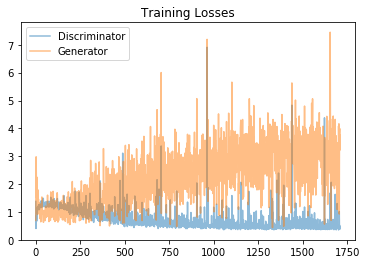

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

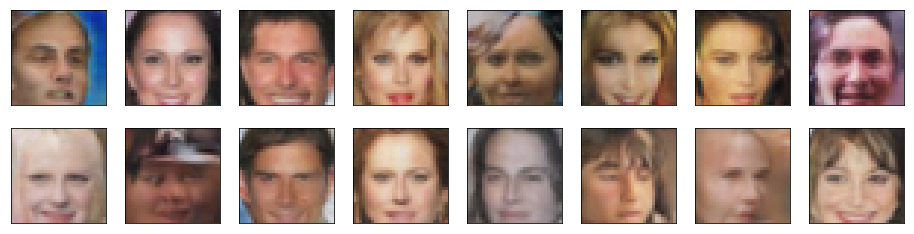

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
- As stated in the question, the generated faces tend to be mostly white which is a result from the biased data. It can be solved by adding more diverse faces.
- Looking at the forth image, there are some strange colors which I think is due to the low training epochs and small model. (Gone after retraining with different hyperparameteres)
- Also the image quality is very low.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.